<a href="https://colab.research.google.com/github/mitkrieg/dl-assignment-1/blob/main/assignment1_practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: DL Basics

### Goal
Implement [LeNet5](https://arxiv.org/pdf/1502.03167v3) and compare various regularization techniques on the network using the FashionMNSIT dataset.

## Library Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import gzip
import typing as T

drive.mount('/content/drive')
torch.manual_seed(123)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Check for GPU Access

In [2]:
print("------ ACCELERATION INFO -----")
print('GPU Available:',torch.cuda.is_available())
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('GPU Name:',torch.cuda.get_device_name(0))
  print('GPU Count:',torch.cuda.device_count())
  print('GPU Memory Allocated:',torch.cuda.memory_allocated(0))
  print('GPU Memory Cached:',torch.cuda.memory_reserved(0))
else:
  device = torch.device('cpu')
  print('Using CPU')

------ ACCELERATION INFO -----
GPU Available: True
GPU Name: Tesla T4
GPU Count: 1
GPU Memory Allocated: 0
GPU Memory Cached: 0


## Load Data using Pytorch

In [3]:

PATH = '/content/drive/MyDrive/Fall 2024/Deep Learning/Assignment 1/data'


### Define FashionMNIST

In [4]:
class FasionMNISTDataset(Dataset):
  def __init__(self, path: str, kind: str, transform=None, target_transform=None, device=None) -> None:
    self.transform = transform
    self.target_transform = target_transform
    self.device = device
    self.labels, self.images = self._load_data(path, kind)

  def _load_data(self, path: str, kind: str) -> T.Tuple[np.ndarray, np.ndarray]:
    with gzip.open(path + f'/{kind}-labels-idx1-ubyte.gz', 'rb') as lable_file:
      lbls = np.frombuffer(lable_file.read(), dtype=np.int8, offset=8)
      lbls = np.copy(lbls)
    with gzip.open(path + f'/{kind}-images-idx3-ubyte.gz', 'rb') as lable_file:
      imgs = np.frombuffer(lable_file.read(), dtype=np.uint8, offset=16).reshape(len(lbls), 1, 28, 28)
      imgs = (np.copy(imgs) / 255).astype(np.float32)
    return lbls, imgs

  def __len__(self) -> int:
    return self.labels.size

  def __getitem__(self, index: int) -> T.Tuple[torch.tensor, torch.tensor]:
    label = torch.tensor(self.labels[index], dtype=torch.long)
    img = torch.tensor(self.images[index])
    if self.device:
      img = img.to(self.device)
      label = label.to(self.device)
    if self.target_transform:
      label = self.target_transform(label)
    if self.transform:
      img = self.transform(img)


    return img, label

def show_img(dataset: Dataset, index: int) -> None:
  img, label = dataset[index]
  labels_map = {
            0: "T-Shirt",
            1: "Trouser",
            2: "Pullover",
            3: "Dress",
            4: "Coat",
            5: "Sandal",
            6: "Shirt",
            7: "Sneaker",
            8: "Bag",
            9: "Ankle Boot",
        }
  plt.imshow(img.cpu().reshape(28,28), cmap='gray')
  plt.title(labels_map[label.cpu().item()])
  plt.show()

### Create Train, Validation and Test sets with loaders

In [5]:
gen = torch.Generator().manual_seed(123)

train = FasionMNISTDataset(PATH, 'train', device=device)
train, val = torch.utils.data.random_split(train, [0.8, 0.2], generator=gen)
test = FasionMNISTDataset(PATH, 'test', device=device)

batch = 128
trainloader = DataLoader(train, batch, shuffle=True, generator=gen)
valloader = DataLoader(val, batch, shuffle=True, generator=gen)
testloader = DataLoader(test, batch, shuffle=True, generator=gen)

#### Example Image

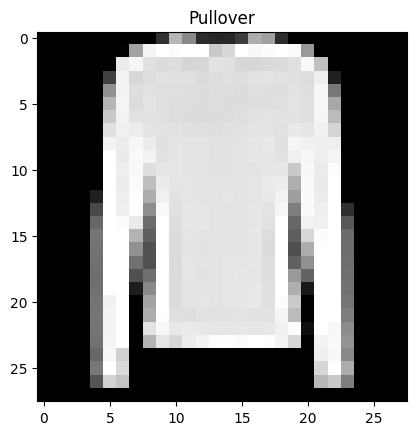

In [6]:
show_img(train, 0)

## LeNet5

In [7]:
class Lenet5(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
    self.max_pool1 = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.max_pool2 = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(16*4*4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84,10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.max_pool1(x)
    x = F.relu(self.conv2(x))
    x = self.max_pool2(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Lenet5()
net.to(device)

cross_entropy = nn.CrossEntropyLoss()
sgd = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)

### Define Training Loop & train LeNet5

In [8]:
def train_network(network, dataloader, loss_fn, optimizer, device, epochs: int, verbosity: int):
  network.train()
  for epoch in range(epochs):
    total_loss = 0
    for i, data in enumerate(dataloader):
      inputs, labels = data

      optimizer.zero_grad()
      outputs = network(inputs)
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()
      if i % verbosity == verbosity - 1:
        print(f'Epoch #{epoch + 1}, Batch #{i + 1}: {total_loss / verbosity}')
        total_loss = 0
  print(f'Done!')

def eval_network(network, dataloader):
  network.eval()
  correct = 0
  total = 0

  with torch.no_grad():
      for data in dataloader:
          images, labels = data
          outputs = network(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'accuracy of the network: {correct}/{total} = {100 * correct / total : .4} %')

train_network(net, trainloader, cross_entropy, sgd, device, 5, 100)
print('Train ', end='')
eval_network(net, trainloader)
print('Val ', end='')
eval_network(net, valloader)


Epoch #1, Batch #100: 2.147723857164383
Epoch #1, Batch #200: 1.0312595248222352
Epoch #1, Batch #300: 0.757422770857811
Epoch #2, Batch #100: 0.6336204895377159
Epoch #2, Batch #200: 0.6282146254181862
Epoch #2, Batch #300: 0.5866017612814903
Epoch #3, Batch #100: 0.5305797564983368
Epoch #3, Batch #200: 0.5131673616170883
Epoch #3, Batch #300: 0.48150057703256605
Epoch #4, Batch #100: 0.4697807604074478
Epoch #4, Batch #200: 0.459765690267086
Epoch #4, Batch #300: 0.447136107981205
Epoch #5, Batch #100: 0.4171407675743103
Epoch #5, Batch #200: 0.4270957589149475
Epoch #5, Batch #300: 0.39771492063999175
Done!
Train accuracy of the network: 41464/48000 =  86.38 %
Val accuracy of the network: 10283/12000 =  85.69 %


### Variations on LeNet5

#### Using Batch Normalization

In [9]:
class Lenet5BN(Lenet5):
    def __init__(self):
        super().__init__()
        self.BN1 = nn.BatchNorm2d(6)
        self.BN2 = nn.BatchNorm2d(16)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.BN1(x))
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(self.BN2(x))
        x = self.max_pool2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net_bn = Lenet5BN()
net_bn.to(device)

cross_entropy = nn.CrossEntropyLoss()
sgd = optim.SGD(net_bn.parameters(), lr=1e-2, momentum=0.9)

train_network(net_bn, trainloader, cross_entropy, sgd, device, 5, 100)
print('Train ', end=' ')
eval_network(net_bn, trainloader)
print('Val ', end=' ')
eval_network(net_bn, valloader)

Epoch #1, Batch #100: 1.3038220250606536
Epoch #1, Batch #200: 0.5854292070865631
Epoch #1, Batch #300: 0.4888907760381699
Epoch #2, Batch #100: 0.41881497979164123
Epoch #2, Batch #200: 0.39451957181096076
Epoch #2, Batch #300: 0.37539498567581175
Epoch #3, Batch #100: 0.3488756538927555
Epoch #3, Batch #200: 0.34425355166196825
Epoch #3, Batch #300: 0.3280733498930931
Epoch #4, Batch #100: 0.30522005036473276
Epoch #4, Batch #200: 0.32480629935860633
Epoch #4, Batch #300: 0.31091489538550376
Epoch #5, Batch #100: 0.29286137610673907
Epoch #5, Batch #200: 0.29689492136240003
Epoch #5, Batch #300: 0.2846573986113071
Done!
Train  accuracy of the network: 43371/48000 =  90.36 %
Val  accuracy of the network: 10682/12000 =  89.02 %


#### Using Dropout

In [18]:
class Lenet5Dropout(Lenet5):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [19]:
net_drop = Lenet5Dropout()
net_drop.to(device)

cross_entropy = nn.CrossEntropyLoss()
sgd = optim.SGD(net_drop.parameters(), lr=1e-2, momentum=0.9)

train_network(net_drop, trainloader, cross_entropy, sgd, device, 5, 100)
print('Train ', end=' ')
eval_network(net_drop, trainloader)
print('Val ', end=' ')
eval_network(net_drop, valloader)

Epoch #1, Batch #100: 2.285408205986023
Epoch #1, Batch #200: 1.3474079966545105
Epoch #1, Batch #300: 0.8963542956113816
Epoch #2, Batch #100: 0.7270633232593536
Epoch #2, Batch #200: 0.687298160791397
Epoch #2, Batch #300: 0.6297478818893433
Epoch #3, Batch #100: 0.5754259520769119
Epoch #3, Batch #200: 0.5448769626021385
Epoch #3, Batch #300: 0.5297683164477348
Epoch #4, Batch #100: 0.5074970871210098
Epoch #4, Batch #200: 0.4983175364136696
Epoch #4, Batch #300: 0.4934162378311157
Epoch #5, Batch #100: 0.45510961502790453
Epoch #5, Batch #200: 0.44631817311048505
Epoch #5, Batch #300: 0.45325106382369995
Done!
Train  accuracy of the network: 40400/48000 =  84.17 %
Val  accuracy of the network: 10062/12000 =  83.85 %


#### Using Weight Decay